<h1> Modelling Spatial Heterogeneity in Real Estate Markets </h1>

<h2> Group 1 – DBSA 2025 – Submission Code </h2>

<h3> Letizia Dimonopoli, Marco Lomele, Giovanni Mantovani, Sofia Villa </h3>


Note: run on Google Colab to avoid environment creation and package installation (recommended).

# Import

In [1]:
# !conda install pymc
# !conda install arviz
# !conda install matplotlib
# !conda install numpy
# !conda install pandas
# !conda install seaborn
# !conda install scipy
# !conda install theano
# !conda install scikit-learn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics import mean_squared_error
from scipy.stats import truncnorm
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pymc as pm
from scipy import stats
import arviz as az

# Data

## Imputation

In [3]:
df = pd.read_csv("housing.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Month'] = df['Date'].dt.month - 1

# Calculate roportion of missing values
initial_rows = df.shape[0]
df_nomissing = df.dropna()
final_rows = df_nomissing.shape[0]
proportion_removed = (initial_rows - final_rows) / initial_rows

initial_rows, final_rows, proportion_removed

(13580, 6196, 0.543740795287187)

In [4]:
missing_values = df.isnull().sum()
missing_values

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
Month               0
dtype: int64

In [5]:
# Imputation of missing values for Car

missing_building_area = df['Car'].isnull().mean()
print(f"Proportion of missing values in Car: {missing_building_area:.2%}")

missing_by_region = df.groupby('CouncilArea')['Car'].apply(lambda x: x.isnull().mean())
print("Proportion of missing Car by CouncilArea:")
print(missing_by_region)

df['lat_rad'] = np.radians(df['Lattitude'])
df['lon_rad'] = np.radians(df['Longtitude'])

coordinates = df[['lat_rad', 'lon_rad']].to_numpy()

missing_car_indices = df[df['Car'].isnull()].index

earth_radius_km = 6371

for idx in missing_car_indices:
    distances = haversine_distances([coordinates[idx]], coordinates) * earth_radius_km
    neighbors = df[(distances[0] <= 10) & (df['Car'].notnull())]
    if not neighbors.empty:
        mean_car_value = neighbors['Car'].mean()
        df.loc[idx, 'Car'] = mean_car_value



missing_building_area = df['Car'].isnull().mean()
print(f"Proportion of missing values in Car: {missing_building_area:.2%}")

Proportion of missing values in Car: 0.46%
Proportion of missing Car by CouncilArea:
CouncilArea
Banyule              0.0
Bayside              0.0
Boroondara           0.0
Brimbank             0.0
Cardinia             0.0
Casey                0.0
Darebin              0.0
Frankston            0.0
Glen Eira            0.0
Greater Dandenong    0.0
Hobsons Bay          0.0
Hume                 0.0
Kingston             0.0
Knox                 0.0
Macedon Ranges       0.0
Manningham           0.0
Maribyrnong          0.0
Maroondah            0.0
Melbourne            0.0
Melton               0.0
Monash               0.0
Moonee Valley        0.0
Moorabool            0.0
Moreland             0.0
Nillumbik            0.0
Port Phillip         0.0
Stonnington          0.0
Unavailable          0.0
Whitehorse           0.0
Whittlesea           0.0
Wyndham              0.0
Yarra                0.0
Yarra Ranges         0.0
Name: Car, dtype: float64
Proportion of missing values in Car: 0.00%


In [6]:
# Imputation of missing values for Building Area

df['Type'] = df['Type'].astype('category').cat.codes  # Encode Type as integer
data = df[['BuildingArea', 'Rooms', 'Landsize', 'Type', 'Price']]

scaler = StandardScaler()
data[['Rooms', 'Landsize', 'Price']] = scaler.fit_transform(data[['Rooms', 'Landsize', 'Price']])

observed_data = data[~data['BuildingArea'].isnull()]
missing_data = data[data['BuildingArea'].isnull()]

X_train = observed_data[['Rooms', 'Landsize', 'Type', 'Price']]
y_train = observed_data['BuildingArea']
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

X_missing = missing_data[['Rooms', 'Landsize', 'Type', 'Price']]
mean_predictions = linear_model.predict(X_missing)

residuals = y_train - linear_model.predict(X_train)
noise_std = np.std(residuals)

def truncated_normal(mean, std, lower=0):
    """
    Sample from a truncated normal distribution.
    """
    a, b = (lower - mean) / std, np.inf  # Truncate below lower limit
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=1)

# Impute missing values
imputed_values = [
    truncated_normal(mean, noise_std, lower=0)[0]  # Ensure positive values
    for mean in mean_predictions
]

data.loc[data['BuildingArea'].isnull(), 'BuildingArea'] = imputed_values

data[['Rooms', 'Landsize', 'Price']] = scaler.inverse_transform(data[['Rooms', 'Landsize', 'Price']])
df['BuildingArea'] = data['BuildingArea']

missing_building_area = df['BuildingArea'].isnull().sum()
print(f"Number of remaining missing values in 'BuildingArea': {missing_building_area}")

negative_values = df[df['BuildingArea'] < 0]
if not negative_values.empty:
    print("There are negative values in 'BuildingArea':")
    print(negative_values)
else:
    print("No negative values in 'BuildingArea'.")

<ipython-input-6-4bacd2b42edb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Rooms', 'Landsize', 'Price']] = scaler.fit_transform(data[['Rooms', 'Landsize', 'Price']])


Number of remaining missing values in 'BuildingArea': 0
No negative values in 'BuildingArea'.


<ipython-input-6-4bacd2b42edb>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['Rooms', 'Landsize', 'Price']] = scaler.inverse_transform(data[['Rooms', 'Landsize', 'Price']])


In [7]:
# Imputation of missing values for Building Area

inconsistent_suburbs = df.groupby('Suburb')['CouncilArea'].nunique()
inconsistent_suburbs = inconsistent_suburbs[inconsistent_suburbs > 1]
if not inconsistent_suburbs.empty:
    print("Suburbs with inconsistent CouncilArea values:")
    print(inconsistent_suburbs)
else:
    print("All suburbs have consistent CouncilArea values.")

# They do NOT have all the same councilarea per suburb so
# the ones that have more than one, I compute the mean.

council_area_locations = df.dropna(subset=['CouncilArea']).groupby('CouncilArea')[
    ['Lattitude', 'Longtitude']
].mean()

suburb_council_mapping = df.dropna(subset=['CouncilArea']).groupby('Suburb')['CouncilArea'].nunique()
single_council_suburbs = suburb_council_mapping[suburb_council_mapping == 1].index.tolist()
multiple_council_suburbs = suburb_council_mapping[suburb_council_mapping > 1].index.tolist()

def find_closest_council(lat, long):
    distances = council_area_locations.apply(
        lambda row: euclidean((lat, long), (row['Lattitude'], row['Longtitude'])), axis=1
    )
    return distances.idxmin()

def impute_councilarea(row):
    if pd.isnull(row['CouncilArea']):  # If CouncilArea is missing
        if row['Suburb'] in single_council_suburbs:
            # Assign the known council area for single-council suburbs
            return df.loc[df['Suburb'] == row['Suburb'], 'CouncilArea'].dropna().iloc[0]
        elif row['Suburb'] in multiple_council_suburbs:
            # Assign the closest council area for multiple-council suburbs
            return find_closest_council(row['Lattitude'], row['Longtitude'])
    return row['CouncilArea']

df['CouncilArea'] = df.apply(impute_councilarea, axis=1)

remaining_missing = df[df['CouncilArea'].isnull()]
for idx, row in remaining_missing.iterrows():
    closest_council = find_closest_council(row['Lattitude'], row['Longtitude'])
    df.at[idx, 'CouncilArea'] = closest_council

missing_council_area = df['CouncilArea'].isnull().mean()
print(f"Proportion of missing values in CouncilArea: {missing_council_area:.2%}")

Suburbs with inconsistent CouncilArea values:
Suburb
Alphington        2
Brighton East     2
Brooklyn          2
Bundoora          3
Burwood           2
Cheltenham        2
Coburg North      2
Eltham North      2
Elwood            2
Fairfield         2
Fawkner           2
Fitzroy North     2
Flemington        2
Glen Iris         2
Greensborough     2
Hampton           2
Hampton East      2
Highett           2
Hillside          2
Keilor East       2
Kensington        2
Mont Albert       2
Oakleigh South    2
Port Melbourne    2
Preston           2
South Yarra       2
Southbank         2
Surrey Hills      2
Windsor           2
Name: CouncilArea, dtype: int64
Proportion of missing values in CouncilArea: 0.00%


In [8]:
# Year built imputation

missing_by_region = df.groupby('CouncilArea')['YearBuilt'].apply(lambda x: x.isnull().mean())
print("Proportion of missing YearBuilt by CouncilArea:")
print(missing_by_region)

missing_by_region = df.groupby('Type')['YearBuilt'].apply(lambda x: x.isnull().mean())
print("Proportion of missing YearBuilt by Type:")
print(missing_by_region)

df['YearBuilt'] = df.groupby(['CouncilArea', 'Type'])['YearBuilt'].transform(
    lambda x: x.fillna(x.mean())
)

df['YearBuilt'] = df.groupby('CouncilArea')['YearBuilt'].transform(
    lambda x: x.fillna(x.mean())
)

df['YearBuilt'] = df.groupby('Type')['YearBuilt'].transform(
    lambda x: x.fillna(x.mean())
)

default_year = df['YearBuilt'].median()
df['YearBuilt'] = df['YearBuilt'].fillna(default_year)

df['YearBuilt'] = df['YearBuilt'].astype(int)

missing_yearbuilt = df['YearBuilt'].isnull().sum()
print(f"Number of remaining missing values in 'YearBuilt': {missing_yearbuilt}")

missing_values = df.isnull().sum()
missing_values

df.to_csv('housing_imputed_final.csv', index=False)
print("Imputation complete. Updated dataset saved.")

Proportion of missing YearBuilt by CouncilArea:
CouncilArea
Banyule              0.428346
Bayside              0.422642
Boroondara           0.395422
Brimbank             0.478079
Cardinia             0.250000
Casey                0.413043
Darebin              0.428856
Frankston            0.367089
Glen Eira            0.384444
Greater Dandenong    0.562500
Hobsons Bay          0.430407
Hume                 0.337398
Kingston             0.402827
Knox                 0.418182
Macedon Ranges       0.454545
Manningham           0.438547
Maribyrnong          0.334243
Maroondah            0.417391
Melbourne            0.372233
Melton               0.273810
Monash               0.428922
Moonee Valley        0.401119
Moorabool            1.000000
Moreland             0.361378
Nillumbik            0.362069
Port Phillip         0.335347
Stonnington          0.392622
Unavailable          0.523810
Whitehorse           0.416887
Whittlesea           0.442478
Wyndham              0.360656
Yarra     

## Analysis

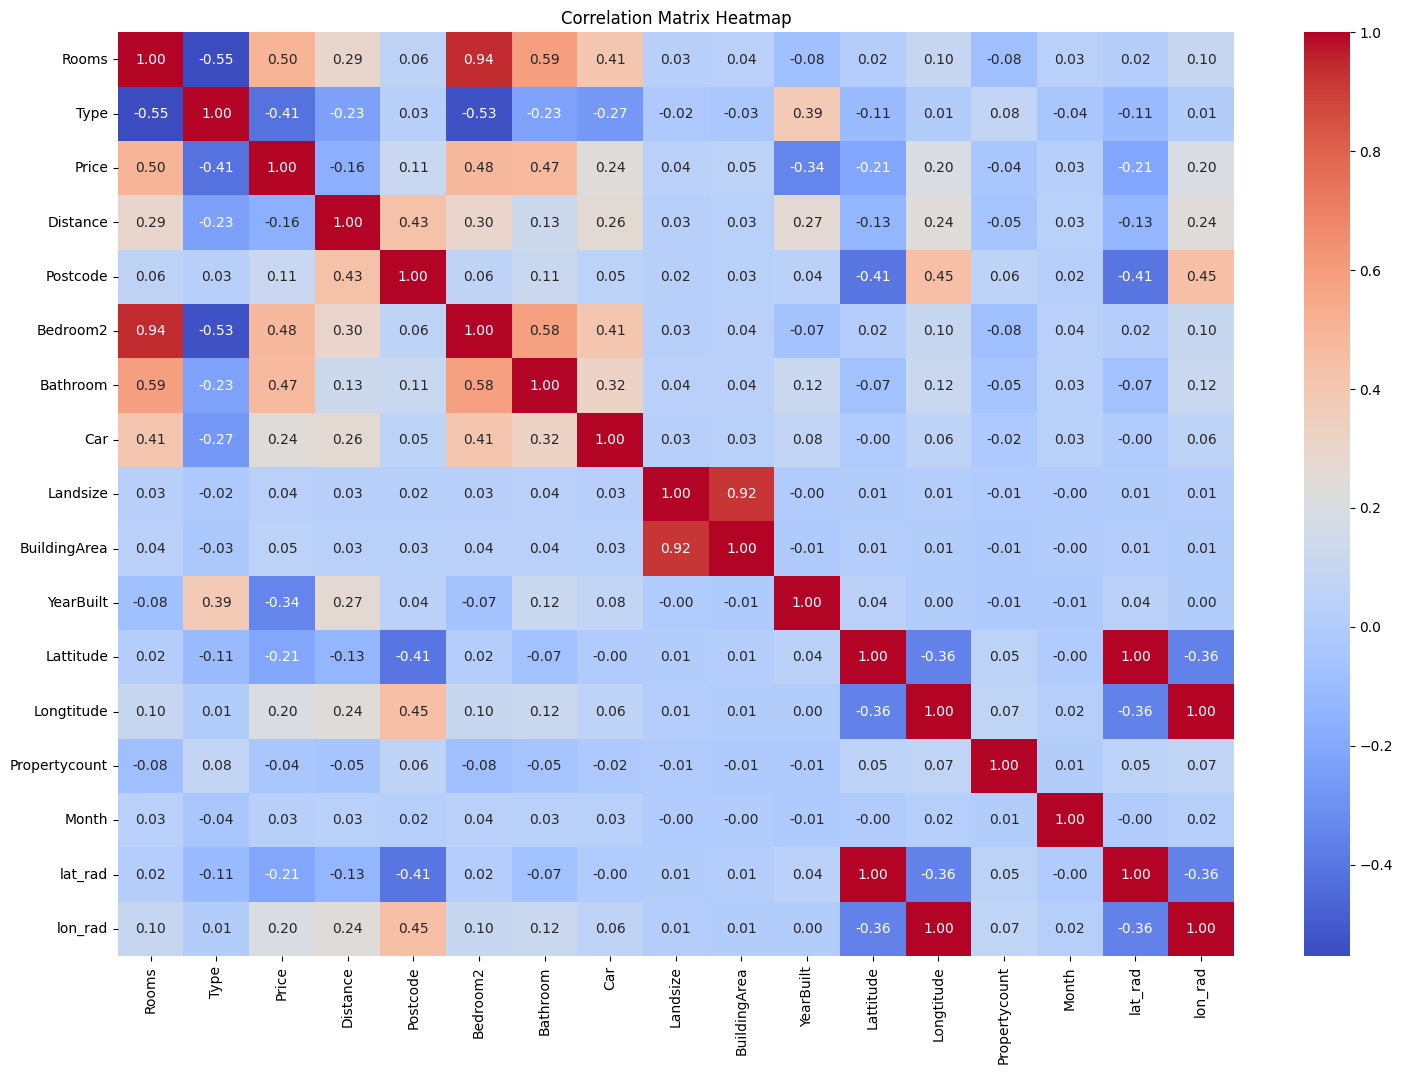

In [9]:
dataset = pd.read_csv('housing_imputed_final.csv')

dataset_numeric = dataset.select_dtypes(include=['number'])
correlation_matrix = dataset_numeric.corr()
plt.figure(figsize=(18, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [10]:
# Calculate IQR for each numerical column
numerical_columns = dataset.select_dtypes(include=np.number).columns
iqr_bounds = {}

# Calculate the IQR bounds for each numerical column
for column in numerical_columns:
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_bounds[column] = (lower_bound, upper_bound)

# Filter the dataset to keep only the observations within the IQR range
filtered_dataset = dataset.copy()
for column, (lower_bound, upper_bound) in iqr_bounds.items():
    filtered_dataset = filtered_dataset[(filtered_dataset[column] >= lower_bound) & (filtered_dataset[column] <= upper_bound)]

# Display the number of observations before and after filtering
original_count = dataset.shape[0]
filtered_count = filtered_dataset.shape[0]

original_count, filtered_count


(13580, 9715)

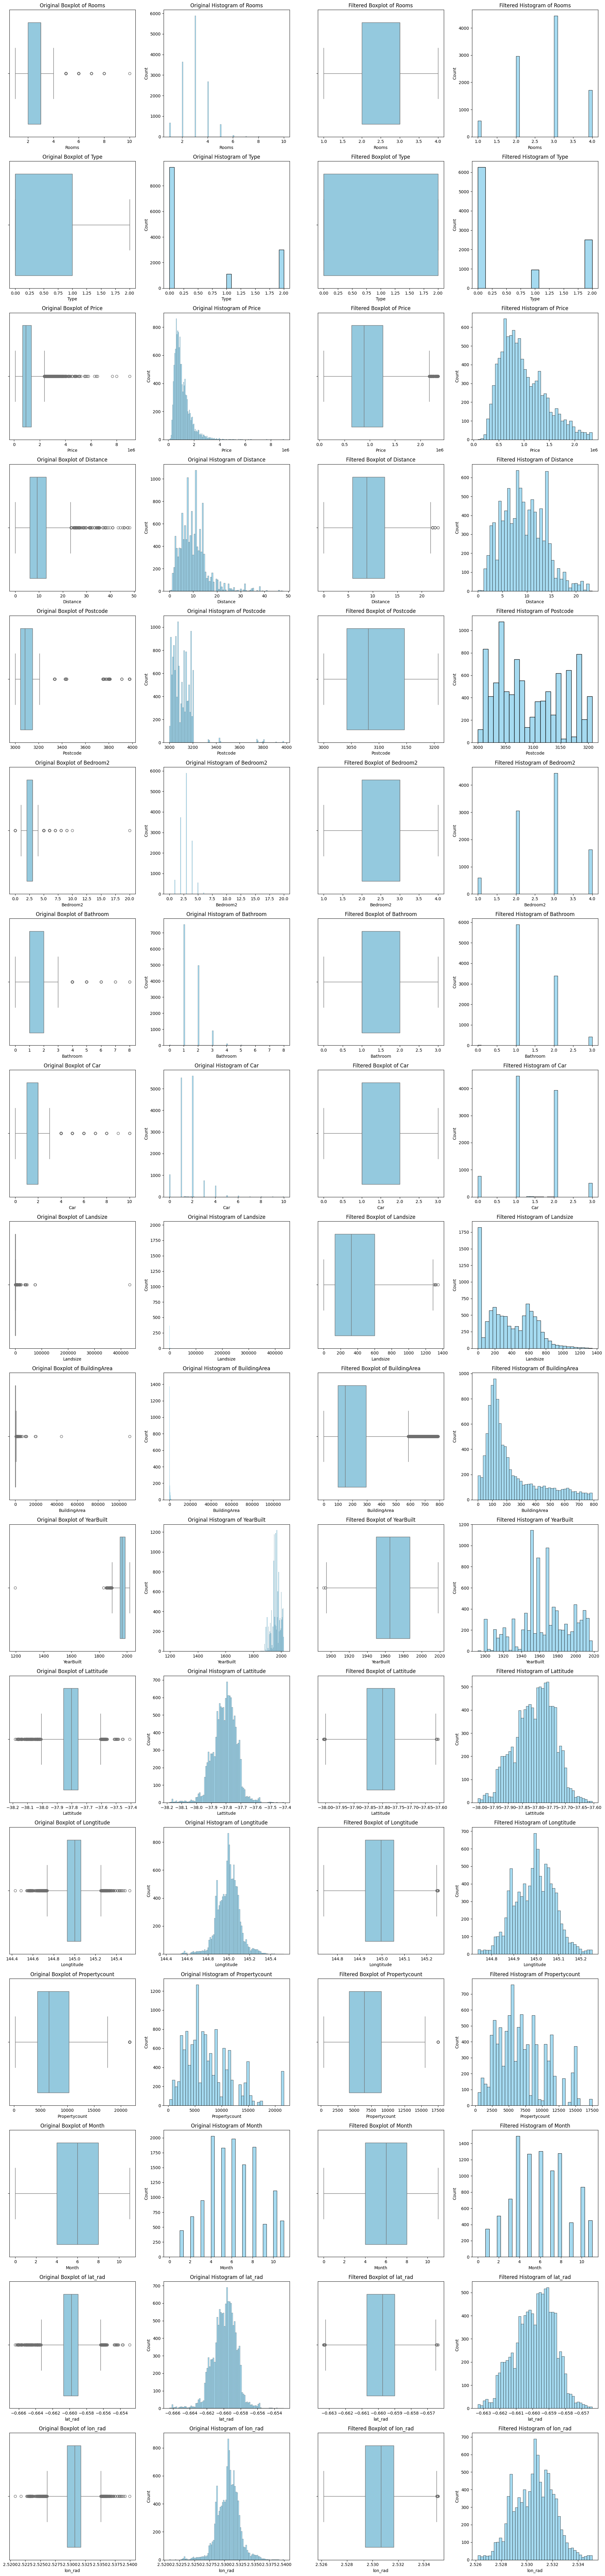

In [11]:
# Function to plot all boxplots and histograms in a single image
def plot_all_comparisons(df_original, df_filtered, columns):
    num_columns = len(columns)
    fig, axs = plt.subplots(num_columns, 4, figsize=(20, 5 * num_columns))
    color = 'skyblue'

    for i, column in enumerate(columns):
        # Original data
        sns.boxplot(x=df_original[column], ax=axs[i, 0], color=color)
        sns.histplot(df_original[column], kde=False, ax=axs[i, 1], color=color)
        axs[i, 0].set_title(f'Original Boxplot of {column}')
        axs[i, 1].set_title(f'Original Histogram of {column}')

        # Filtered data
        sns.boxplot(x=df_filtered[column], ax=axs[i, 2], color=color)
        sns.histplot(df_filtered[column], kde=False, ax=axs[i, 3], color=color)
        axs[i, 2].set_title(f'Filtered Boxplot of {column}')
        axs[i, 3].set_title(f'Filtered Histogram of {column}')

    plt.tight_layout()
    plt.show()

# Plot comparisons for all numerical columns
plot_all_comparisons(dataset, filtered_dataset, numerical_columns)

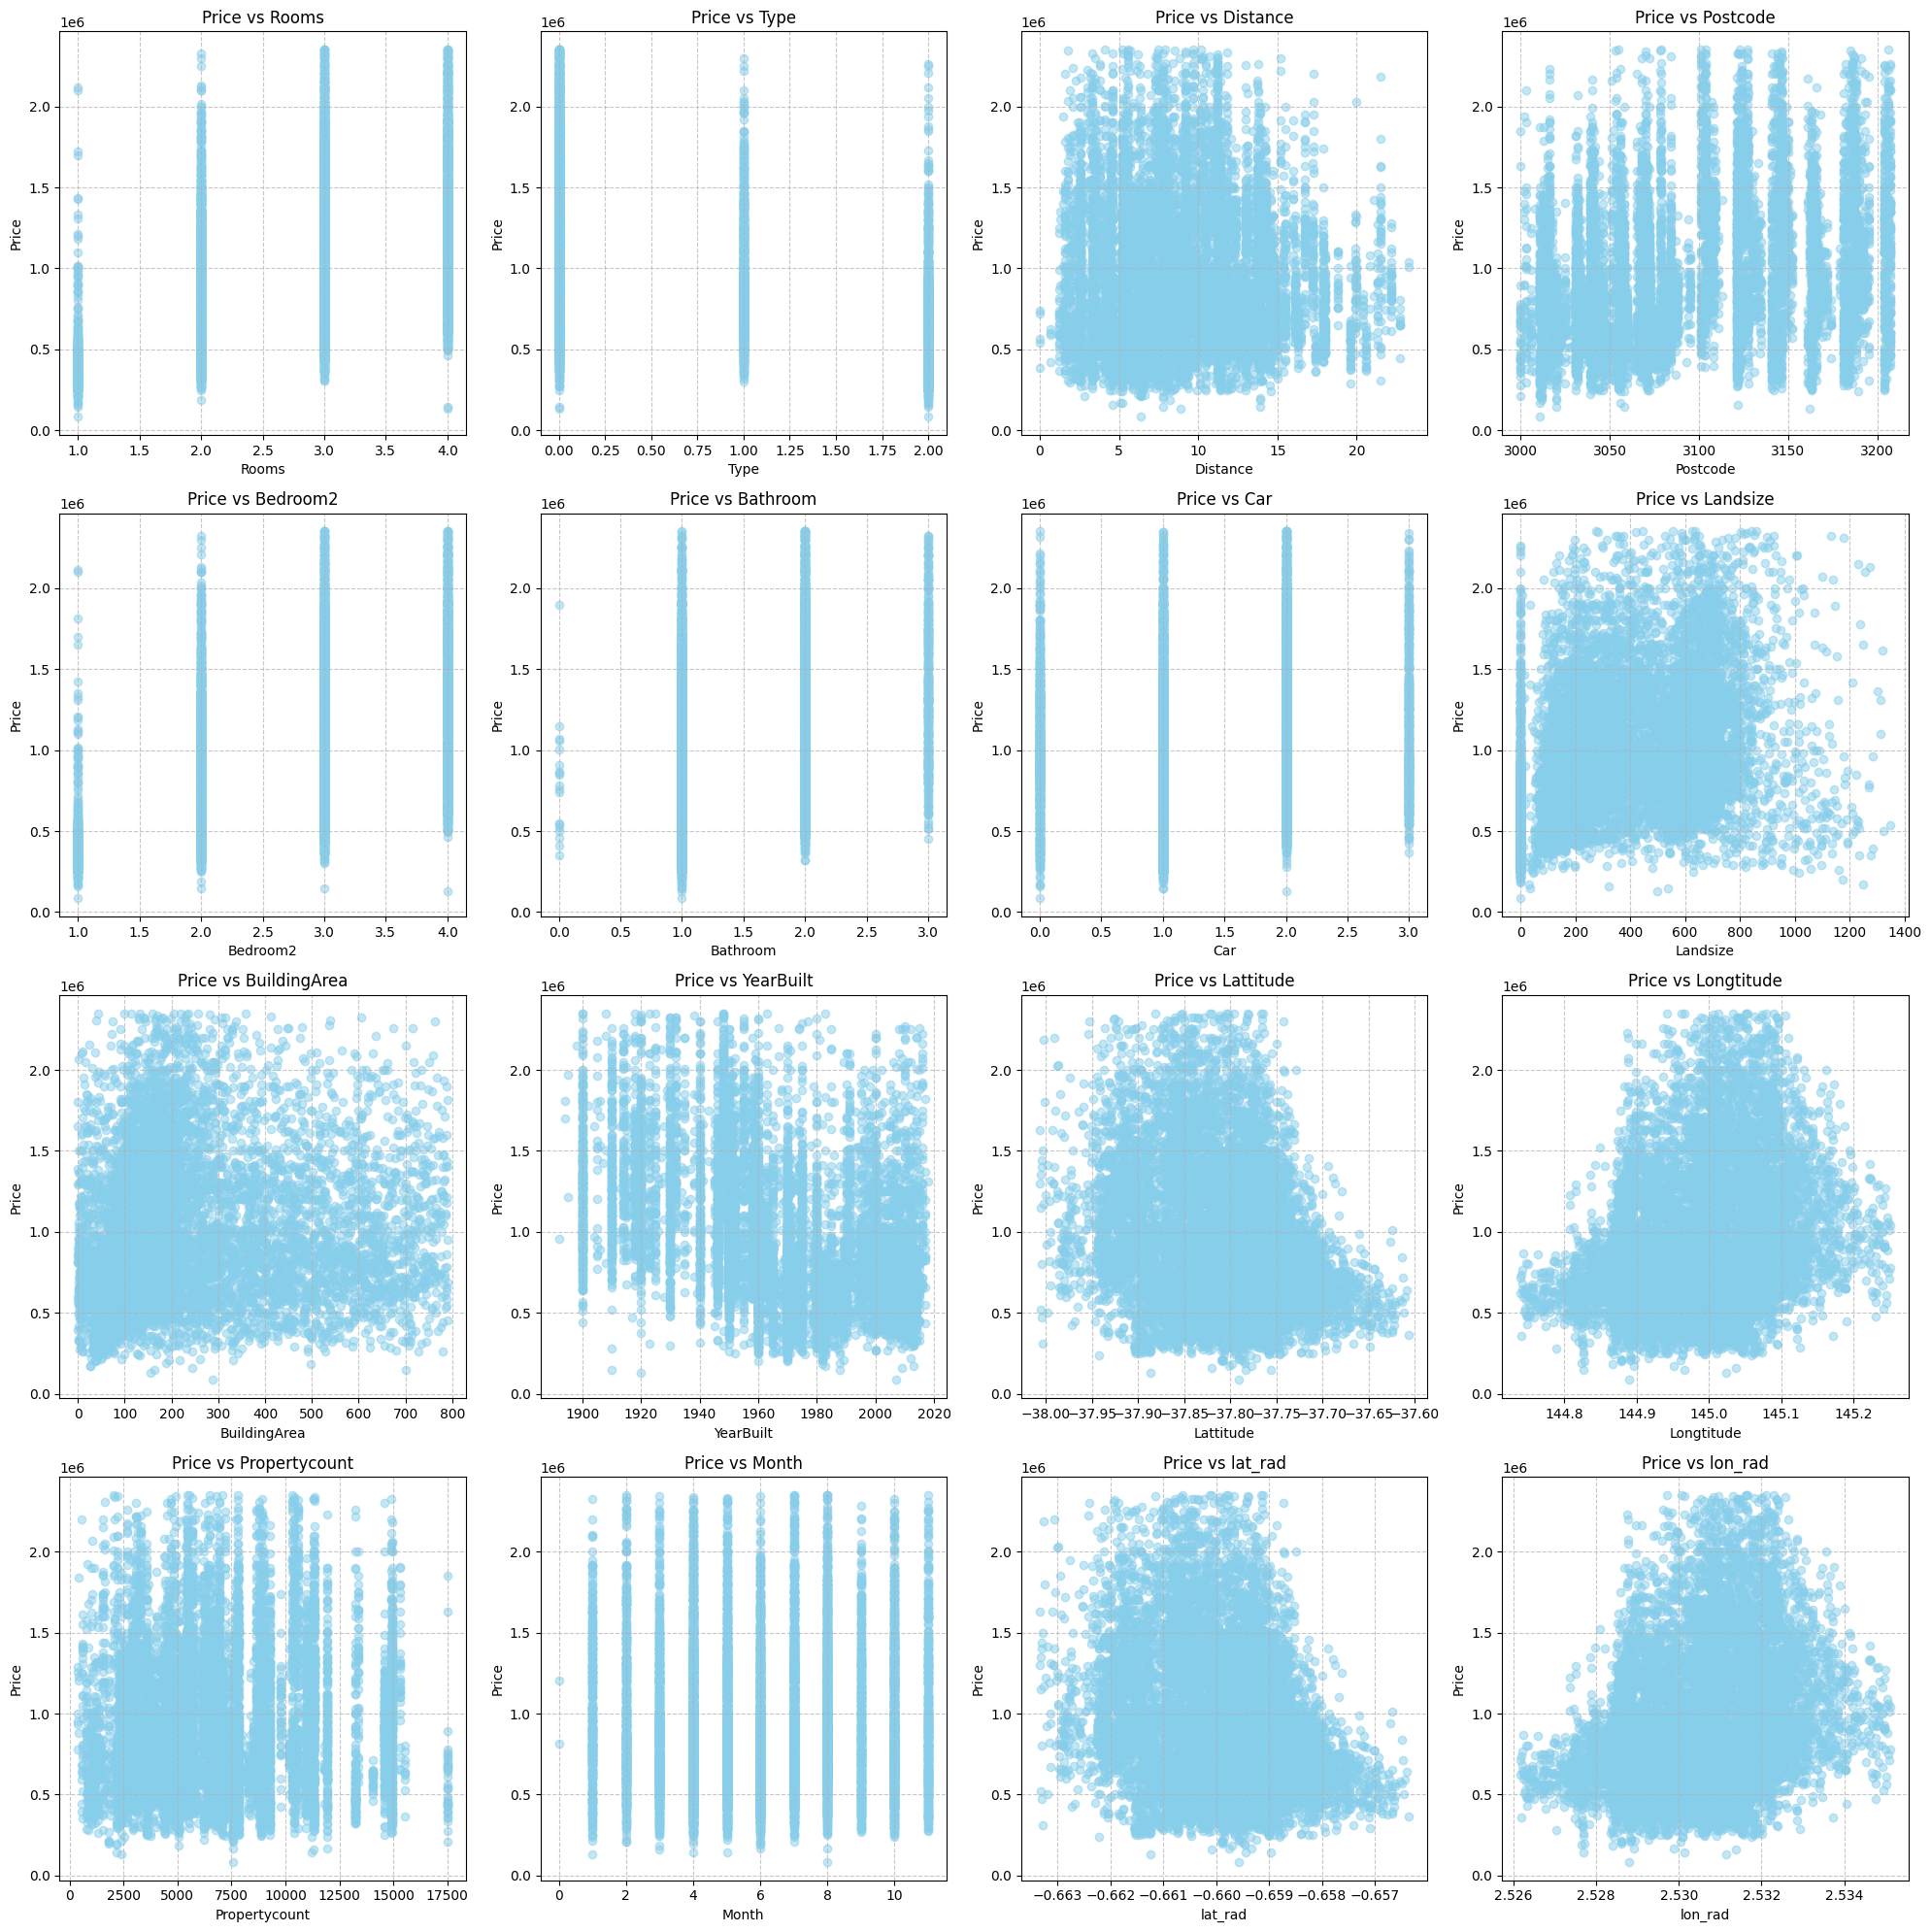

In [12]:
# grid of scatterplots plotting price vs all the other variables in the dataset

numerical_vars = list(numerical_columns)
numerical_vars.remove('Price')
filtered_dataset.loc[:, 'Car'] = filtered_dataset['Car'].round(0).astype(int)


def plot_all_scatterplots(df_filtered, numerical_vars):
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    color = 'skyblue'

    for idx, var in enumerate(numerical_vars):
        row = idx // 4
        col = idx % 4

        # Create scatter plot
        axs[row, col].scatter(df_filtered[var], df_filtered['Price'], color=color, alpha=0.5)

        # Add labels and title
        axs[row, col].set_xlabel(var)
        axs[row, col].set_ylabel('Price')
        axs[row, col].set_title(f'Price vs {var}')

        # Add grid
        axs[row, col].grid(True, linestyle='--', alpha=0.7)

    # Remove empty subplots if any
    for idx in range(len(numerical_vars), 16):
        row = idx // 4
        col = idx % 4
        fig.delaxes(axs[row, col])

    plt.tight_layout()
    plt.show()

# Plot comparisons for all numerical columns
plot_all_scatterplots(filtered_dataset, numerical_vars)

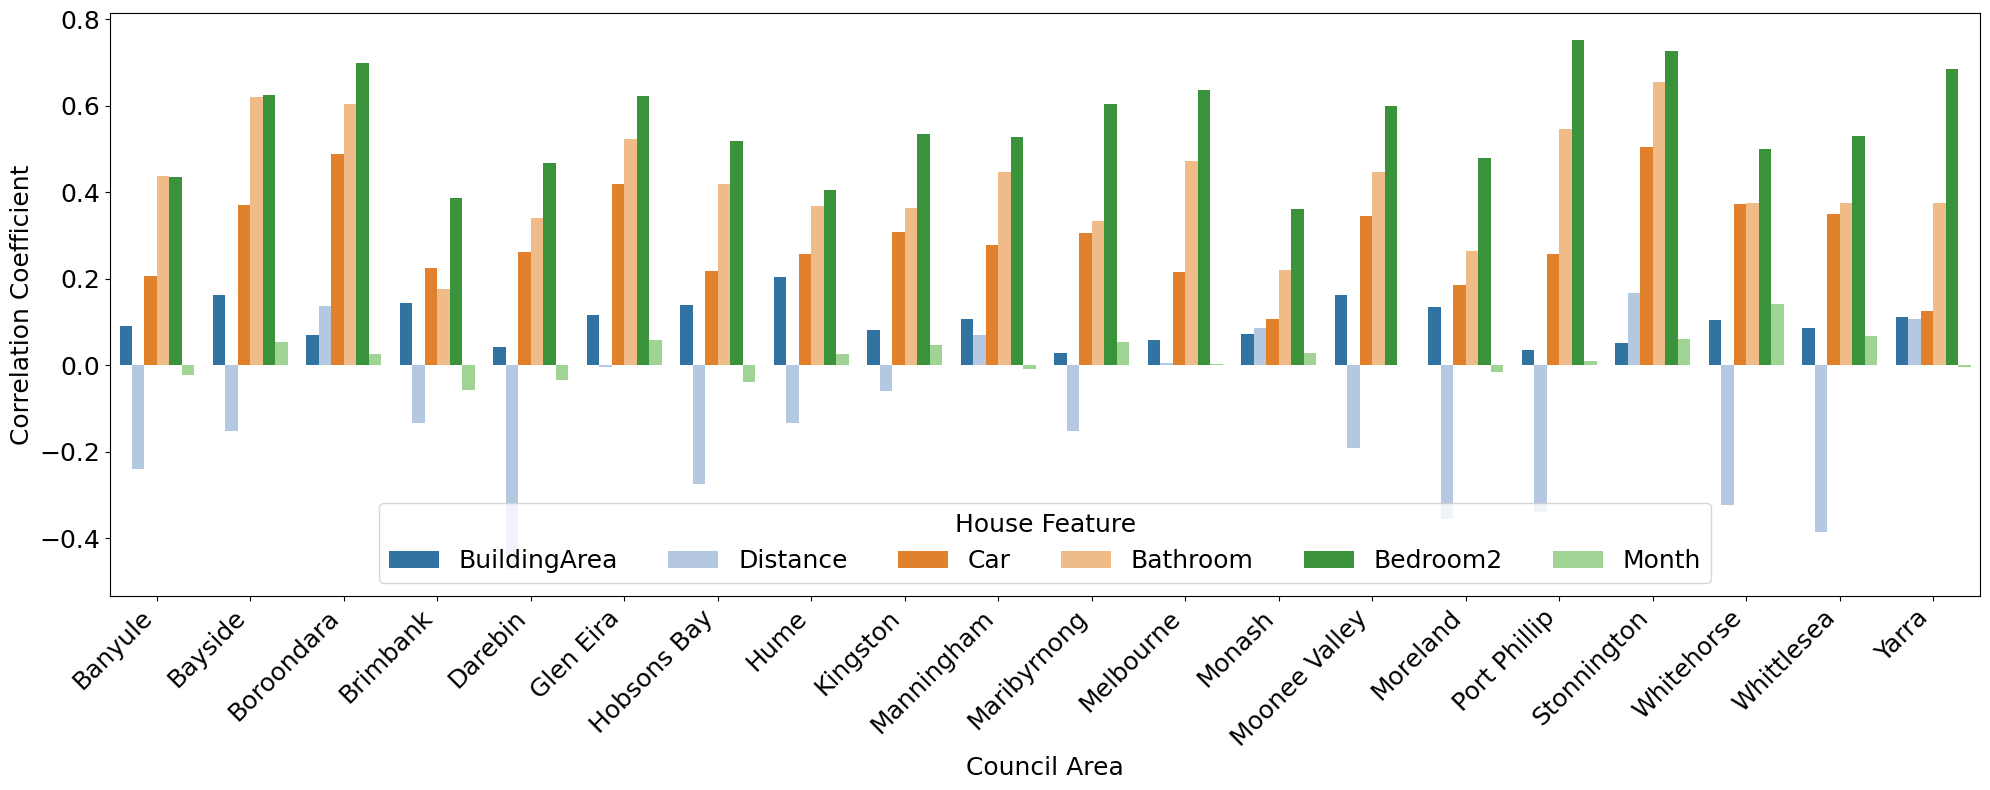

In [13]:
columns_of_interest = ['Price', 'BuildingArea', 'Distance', 'Car', 'Bathroom', 'Bedroom2', 'Month']
specified_council_areas = ['Banyule', 'Bayside', 'Boroondara', 'Brimbank', 'Darebin',
                           'Glen Eira', 'Hobsons Bay', 'Hume', 'Kingston', 'Manningham',
                           'Maribyrnong', 'Melbourne', 'Monash', 'Moonee Valley', 'Moreland',
                           'Port Phillip', 'Stonnington', 'Whitehorse', 'Whittlesea', 'Yarra']

filtered_df = df[df['CouncilArea'].isin(specified_council_areas)]

df_subset = filtered_df[['CouncilArea'] + columns_of_interest].dropna()

correlation_results = []

for council, group in df_subset.groupby('CouncilArea'):
    corr = group[columns_of_interest].corr()['Price'].drop('Price')  # Correlation with 'Price'
    for covariate, coef in corr.items():
        correlation_results.append({'CouncilArea': council, 'Covariate': covariate, 'Correlation': coef})

corr_df = pd.DataFrame(correlation_results)
custom_palette = sns.color_palette("tab20", len(columns_of_interest) - 1)

plt.figure(figsize=(20, 8))
sns.barplot(data=corr_df, x='CouncilArea', y='Correlation', hue='Covariate', palette=custom_palette)

plt.xticks(rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
#plt.title('Correlation of Covariates with Price by Council Area')
plt.ylabel('Correlation Coefficient', fontsize=18)
plt.xlabel('Council Area', fontsize=18)
plt.legend(title='House Feature', loc='lower center', title_fontsize=18, fontsize=18, ncol=6)
plt.tight_layout()
plt.show()

In [14]:
dataset = dataset[dataset['Rooms'] <= 20]

price_cap = dataset['Price'].quantile(0.99)
landsize_cap = dataset['Landsize'].quantile(0.99)
rooms_cap = dataset['Rooms'].quantile(0.99)
car_cap = dataset['Car'].quantile(0.99)

dataset['Price'] = dataset['Price'].clip(upper=price_cap)
dataset['Landsize'] = dataset['Landsize'].clip(upper=landsize_cap)
dataset['Rooms'] = dataset['Rooms'].clip(upper=rooms_cap)
dataset['Car'] = dataset['Car'].clip(upper=car_cap)

dataset['Price_log'] = dataset['Price'].apply(lambda x: np.log1p(x))
dataset['Landsize_log'] = dataset['Landsize'].apply(lambda x: np.log1p(x))

building_area_min_threshold = 10  # reasonable lower limit
building_area_cap = dataset['BuildingArea'].quantile(0.99)

dataset = dataset[dataset['BuildingArea'] > building_area_min_threshold]
dataset['BuildingArea'] = dataset['BuildingArea'].clip(upper=building_area_cap)

#cleaned_file_path = 'housing_cleaned.csv'
#dataset.to_csv(cleaned_file_path, index=False)

print(dataset[['Price', 'Landsize', 'BuildingArea', 'Rooms', 'Car']].describe())

              Price      Landsize  BuildingArea         Rooms           Car
count  1.341400e+04  13414.000000  13414.000000  13414.000000  13414.000000
mean   1.068213e+06    468.364461    290.892619      2.932235      1.602051
std    5.952418e+05    433.379835    272.901717      0.928656      0.921112
min    8.500000e+04      0.000000     10.032318      1.000000      0.000000
25%    6.500000e+05    178.000000    109.000000      2.000000      1.000000
50%    9.050000e+05    444.000000    175.013584      3.000000      2.000000
75%    1.330000e+06    651.000000    385.757759      3.000000      2.000000
max    3.338150e+06   2959.830000   1292.947371      5.000000      5.000000


<ipython-input-32-7e638c0a5037>:93: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Static visualization saved as: melbourne_housing_heatmap.png


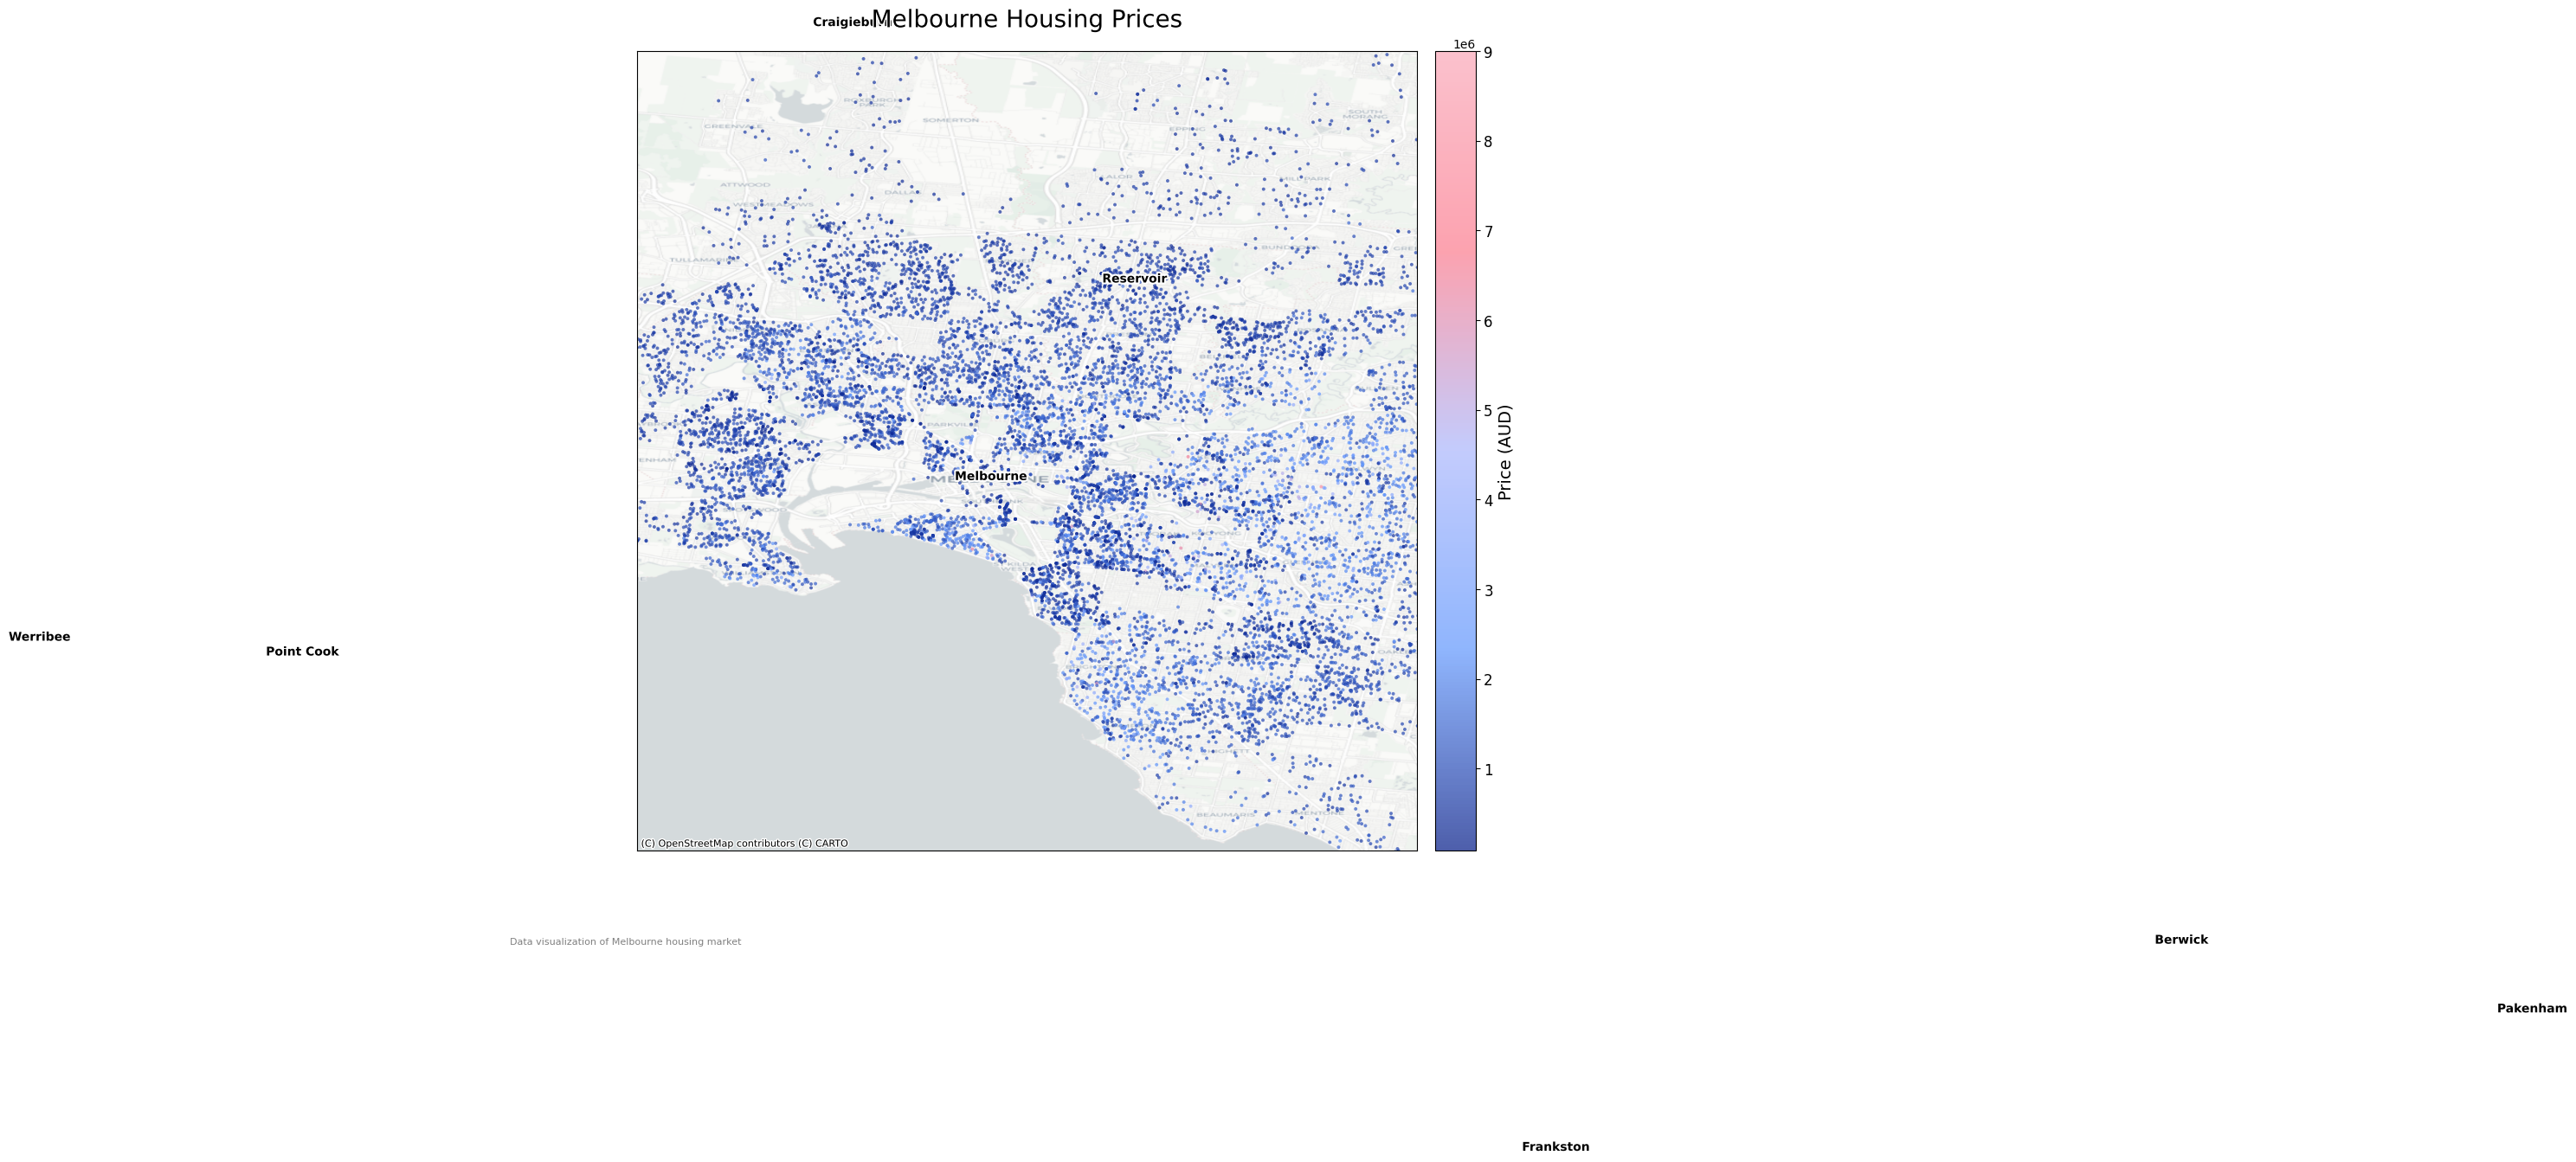

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects

# Load the dataset
df = pd.read_csv("housing_imputed_final.csv")

# Filter out any rows with missing coordinates
df = df.dropna(subset=['Lattitude', 'Longtitude', 'Price'])

# Create figure and axis with a specific figure size
fig, ax = plt.subplots(figsize=(14, 12))

# Define a custom colormap for the heatmap
colors = ["#031b88", "#6096fd", "#aab6fd", "#fb7b8e", "#faa7b8"]
custom_cmap = LinearSegmentedColormap.from_list("custom_green_blue", colors)

# Create scatter plot with colors based on price
scatter = ax.scatter(
    df['Longtitude'],
    df['Lattitude'],
    c=df['Price'],
    cmap=custom_cmap,
    alpha=0.7,
    s=8,  # Point size
    edgecolors='none'
)

# Add a basemap from contextily
ctx.add_basemap(
    ax,
    crs='EPSG:4326',  # The coordinate reference system of our data
    source=ctx.providers.CartoDB.Positron,  # A clean, light-colored basemap
    zoom=12
)

# Set plot limits to focus on Melbourne area
buffer = 0.05
ax.set_xlim([144.85, 145.1])
ax.set_ylim([-38, -37.6])

# Remove axis ticks and labels for a cleaner map
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Add a title with a nice style
title = ax.set_title('Melbourne Housing Prices', fontsize=20, pad=20)
title.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

# Add a color bar for price reference
cbar = fig.colorbar(scatter, ax=ax, pad=0.02)
cbar.set_label('Price (AUD)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Label some key suburbs
top_suburbs = df.groupby('Suburb').agg({
    'Price': 'mean',
    'Lattitude': 'mean',
    'Longtitude': 'mean',
    'Propertycount': 'first'
}).sort_values('Propertycount', ascending=False).head(8)

for idx, row in top_suburbs.iterrows():
    text = ax.text(
        row['Longtitude'],
        row['Lattitude'],
        idx,
        fontsize=10,
        ha='center',
        va='center',
        color='black',
        fontweight='bold'
    )
    text.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

# Add a subtle grid for reference
ax.grid(alpha=0.2, linestyle='--')

# Add a watermark/caption
plt.figtext(
    0.02, 0.02,
    'Data visualization of Melbourne housing market',
    fontsize=8,
    color='gray'
)

# Set a tight layout and save the figure as a high-resolution PNG
plt.tight_layout()
plt.savefig('melbourne_housing_heatmap.png', dpi=300, bbox_inches='tight')
print("Static visualization saved as: melbourne_housing_heatmap.png")

## Preparation

In [15]:
housing_data = pd.read_csv('housing_imputed_final.csv')

data_subset = housing_data[['Price', 'BuildingArea', 'CouncilArea', 'Distance', 'Car', 'Bathroom', 'Bedroom2', 'Month']]

#fix Car variable
data_subset.loc[:, 'Car'] = data_subset['Car'].round(0).astype(int)

# Filter council areas with more than 200 observations
group_counts = data_subset['CouncilArea'].value_counts()
valid_council_areas = group_counts[group_counts > 200].index
filtered_data = data_subset[data_subset['CouncilArea'].isin(valid_council_areas)]

def remove_extreme_outliers(df, column, lower_limit, upper_limit):
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

# Outliers – consider observations within inter quartile range of features
def remove_extreme_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

for col in ['Price', 'BuildingArea', 'Distance', 'Car', 'Bathroom', 'Bedroom2']:
    filtered_data = remove_extreme_outliers_iqr(filtered_data, col)

# Standardize Price and BuildingArea
scaler = StandardScaler()
filtered_data.loc[:, ['Price', 'BuildingArea', 'Distance', 'Car', 'Bathroom', 'Bedroom2']] = scaler.fit_transform(filtered_data[['Price', 'BuildingArea', 'Distance', 'Car', 'Bathroom', 'Bedroom2']])

# Prepare variables for the Bayesian model – change for other 4 models
y = filtered_data['Price'].values
X = filtered_data[['Car', 'Distance', 'Bathroom', 'Bedroom2']].values
Z = filtered_data['BuildingArea'].values

council_idx = filtered_data['CouncilArea'].astype('category').cat.codes # CouncilArea as numeric index
month_idx = filtered_data['Month'].values  # Month as numeric index

n_councils = len(filtered_data['CouncilArea'].unique())

#adjacenty matrix
council_neighbours = {
    'Banyule': ['Manningham', 'Darebin', 'Boroondara', 'Whittlesea', 'Yarra'],
    'Bayside': ['Glen Eira', 'Kingston', 'Port Phillip'],
    'Boroondara': ['Manningham', 'Whitehorse', 'Monash', 'Stonnington', 'Yarra', 'Banyule'],
    'Brimbank': ['Hume', 'Maribyrnong', 'Moonee Valley', 'Hobsons Bay'],
    'Darebin': ['Banyule', 'Whittlesea', 'Moreland', 'Yarra'],
    'Glen Eira': ['Bayside', 'Port Phillip', 'Stonnington', 'Monash', 'Kingston'],
    'Hobsons Bay': ['Maribyrnong', 'Brimbank'],
    'Hume': ['Whittlesea', 'Moreland', 'Moonee Valley', 'Brimbank'],
    'Kingston': ['Bayside', 'Glen Eira', 'Monash'],
    'Manningham': ['Banyule', 'Whitehorse', 'Boroondara'],
    'Maribyrnong': ['Moonee Valley', 'Melbourne', 'Hobsons Bay', 'Brimbank'],
    'Melbourne': ['Yarra', 'Stonnington', 'Port Phillip', 'Maribyrnong', 'Moonee Valley', 'Moreland'],
    'Monash': ['Whitehorse', 'Glen Eira', 'Kingston', 'Boroondara', 'Stonnington'],
    'Moonee Valley': ['Moreland', 'Melbourne', 'Maribyrnong', 'Brimbank', 'Hume'],
    'Moreland': ['Darebin', 'Yarra', 'Melbourne', 'Moonee Valley', 'Hume'],
    'Port Phillip': ['Melbourne', 'Stonnington', 'Glen Eira', 'Bayside'],
    'Stonnington': ['Melbourne', 'Yarra', 'Boroondara', 'Glen Eira', 'Port Phillip', 'Monash'],
    'Whittlesea': ['Hume', 'Darebin', 'Banyule'],
    'Whitehorse': ['Manningham', 'Monash', 'Boroondara'],
    'Yarra': ['Darebin', 'Boroondara', 'Banyule', 'Stonnington', 'Melbourne', 'Moreland'],
}

council_to_council_idx = {c: i for i, c in enumerate(sorted(filtered_data['CouncilArea'].unique()))}
council_neighbours_idx = {council_to_council_idx[c]: [council_to_council_idx[n] for n in ns] for c, ns in council_neighbours.items()}

adjacency_matrix = np.zeros((n_councils, n_councils))
for key in list(council_neighbours_idx.keys()):
    for value in council_neighbours_idx[key]:
        adjacency_matrix[key, value] = 1

n_neighbors = adjacency_matrix.sum(axis=1)
D = np.diag(n_neighbors)
# W = np.diag(1/n_neighbors) @ adjacency_matrix

#compute eigenvalues of adjancency_matrix
eigenvalues, eigenvectors = np.linalg.eig(adjacency_matrix)

#compute range of smoothing param such that var-covar is positive-definite
min_rho, max_rho = 1/eigenvalues.min(), 1/eigenvalues.max()
# print(f"Minimum spatial dependency smoothing: {min_rho:.4f}")
# print(f"Maximum spatial dependency smoothing: {max_rho:.4f}")

# Modelling

## Model Definition and Priors

In [ ]:
with pm.Model() as model:
    # Priors for variances
    sigma_month = pm.InverseGamma('sigma_month', alpha=2, beta=1)
    sigma_council = pm.InverseGamma('sigma_council', alpha=2, beta=1)
    sigma_slope = pm.InverseGamma('sigma_slope', alpha=2, beta=1)
    sigma_eps = pm.InverseGamma('sigma_eps', alpha=2, beta=1)

    # Fixed effects (betas)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=4)

    ## Random effects - non-centered parameterization
    # Month random intercepts
    month_offset = pm.Normal('month_offset', 0, 1, shape=12)
    t = pm.Deterministic('t', month_offset * sigma_month)

    # Council random intercepts
    rho = 0.1
    alpha = 0.09
    Q = alpha**2 * pm.math.matrix_inverse(D - rho * adjacency_matrix)

    council_offset = pm.MvNormal('council_offset', mu=np.zeros(n_councils), tau=Q, shape=n_councils)
    u = pm.Deterministic('u', council_offset * sigma_council)

    # Council random slopes for Z
    slope_offset = pm.Normal('slope_offset', 0, 1, shape=n_councils)
    v = pm.Deterministic('v', slope_offset * sigma_slope)

    # Linear predictor
    mu =  (t[month_idx] +  # Month RE
          u[council_idx] +  # Council RE
          pm.math.dot(X, beta) +  # Fixed effects
          Z * v[council_idx])  # Random slope

    # Likelihood
    y_obs = pm.StudentT('y_obs', nu=4, mu=mu, sigma=sigma_eps, observed=y)

## Inference

In [ ]:
do_inference = True
if do_inference:
    while True:
        with model:
            trace = pm.sample(
                draws=3000,
                tune=3000,
                target_accept=0.95,
                chains=4,
                cores=1,
                init='adapt_diag',
                max_treedepth=15,
                return_inferencedata=True
            )
            break

## Results

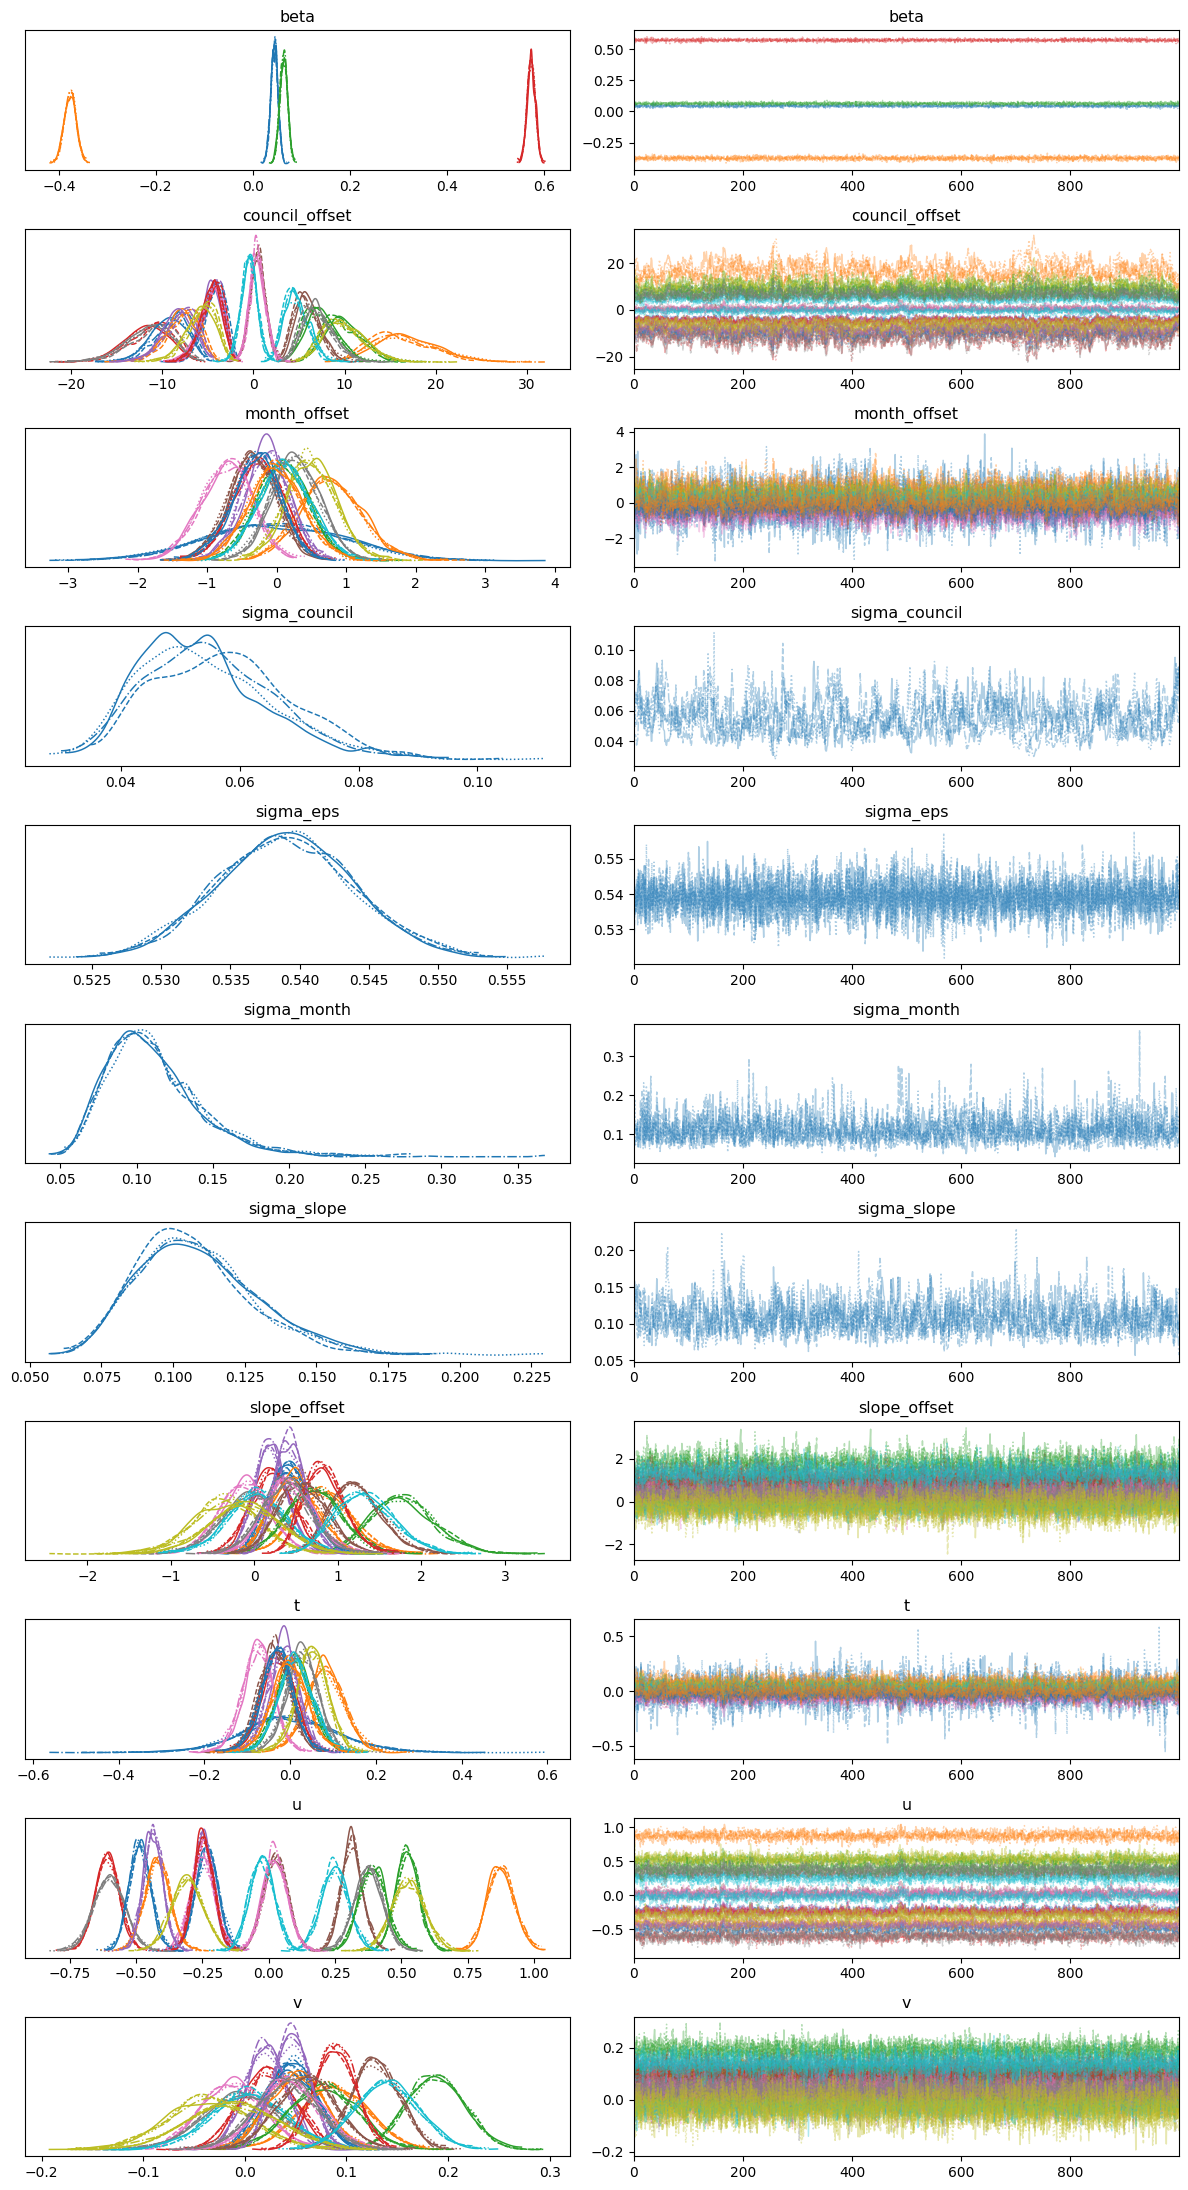

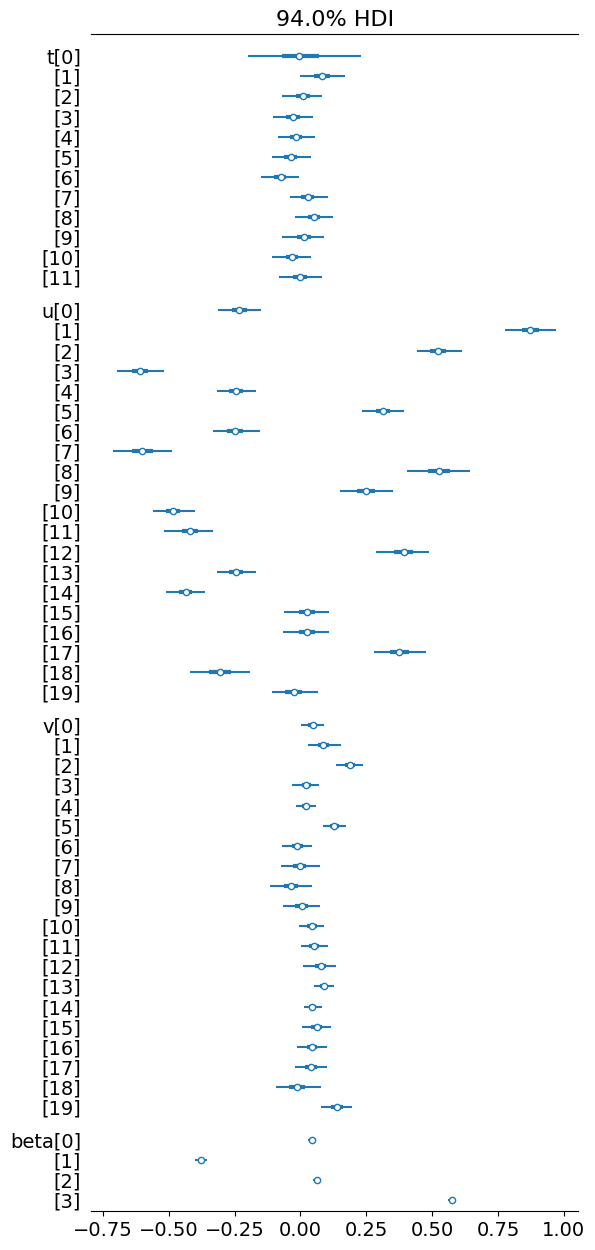

In [ ]:
summary = pm.summary(trace).reset_index().rename(columns={'index':'variable'})
summary.to_csv('summary')

axes = az.plot_trace(trace)
fig = plt.gcf()
fig.tight_layout()
plt.show()

az.plot_forest(trace, var_names=['t', 'u', 'v', 'beta'], combined=True)
plt.tight_layout()